# Распознаем цифры

Сразу включим всё, что использовали на лекции.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
# np.random.seed(42)

import librosa
import librosa.display
import IPython.display as ipd
import pandas as pd

In [2]:
import os
import PIL

IMAGE_TRAIN_PATH = "./data/train/image"
VOICE_TRAIN_PATH = "./data/train/voice"
IMAGE_TEST_PATH = "./data/test/image/"
VOICE_TEST_PATH = "./data/test/voice/"

def read_image(path):
    return PIL.Image.open(path).convert('L')
def load_wav(path):
    return librosa.load(path, sr=8000)

Загрузим модели и средства перекрёстной проверки.

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

###  Извлечение признаков

In [4]:
def extract_image_features(image_folder):
    image_vectors = []
    indices = []
    for image_name in os.listdir(image_folder):
        index = os.path.splitext(image_name)[0]
        indices.append(index)
        image = read_image(os.path.join(image_folder, image_name))
        image_vector = np.array(image).reshape(-1)
        image_vectors.append(image_vector)
    return pd.DataFrame({
        'index': indices,
        'image_vector': image_vectors,
    })

In [5]:
image_features = extract_image_features(IMAGE_TRAIN_PATH)

In [6]:
image_features.head(3)

,index,image_vector
0,0_0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,0_1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,0_10,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [7]:
def extract_voice_features(voice_folder, numcep=16, hop_length=256):
    voice_vectors = []
    indices = []
    for record_name in os.listdir(voice_folder):
        index = os.path.splitext(record_name)[0]
        indices.append(index)
        signal, sr = load_wav(
            os.path.join(voice_folder, record_name)
        )
        mfcc_features = librosa.feature.mfcc(
            signal, sr=sr, n_mfcc=numcep, hop_length=hop_length
        )
        voice_vector = mfcc_features.mean(axis=1)
        voice_vectors.append(voice_vector)
    return pd.DataFrame({
        'index': indices,
        'voice_vector': voice_vectors,
    })

In [8]:
voice_features = extract_voice_features(VOICE_TRAIN_PATH)

In [9]:
voice_features.head(3)

,index,voice_vector
0,0_0,"[-206.83414255852185, 57.27340509868273, 17.93..."
1,0_1,"[-219.53283419210226, 56.91259734891663, 35.57..."
2,0_10,"[-400.8118128999196, 54.28934451595202, 1.0990..."


In [10]:
dataset = image_features.merge(voice_features, on='index')
dataset["target"] = dataset["index"].apply(lambda x: int(x[0]))

In [12]:
sigma=np.std(np.vstack(dataset["image_vector"]), axis=0)
dataset["im_short"]=list(map(lambda x: np.extract(sigma>64,x),dataset["image_vector"]))
dataset.head(3)

,index,image_vector,voice_vector,target,im_short
0,0_0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-206.83414255852185, 57.27340509868273, 17.93...",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 43, 145, 235, 235,..."
1,0_1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-219.53283419210226, 56.91259734891663, 35.57...",0,"[0, 47, 150, 253, 253, 63, 0, 0, 11, 155, 233,..."
2,0_10,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-400.8118128999196, 54.28934451595202, 1.0990...",0,"[0, 0, 0, 0, 0, 0, 0, 20, 134, 253, 253, 255, ..."


In [13]:
submit_image_features = extract_image_features(IMAGE_TEST_PATH)
submit_voice_features = extract_voice_features(VOICE_TEST_PATH)
submit_dataset = submit_image_features.merge(
    submit_voice_features, 
    on="index"
)
submit_dataset["index"] = submit_dataset["index"].apply(int)
submit_dataset.head(3)

,index,image_vector,voice_vector
0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-314.85054916612467, 92.66636306282136, -20.0..."
1,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-379.8489601033069, 20.240626903812768, 27.49..."
2,10,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-176.60444192796464, 102.20920327426838, -18...."


### Улучшим предсказание по звуку.

 [Здесь](https://habr.com/ru/post/140828/) сказано, что рекомендуется брать от 13 до 24 мел-частотных спектральных коэффициентов, но хороший результат начинается с 16. Значит формирование данных по первым 13 нас не устроит.

In [14]:
for i in range(13,24,1):
    voice_features = extract_voice_features(VOICE_TRAIN_PATH, numcep=i)
    X = np.vstack(voice_features["voice_vector"])
    y=dataset["target"]
    mdl_all = RandomForestClassifier(n_estimators=500)
    print(np.mean(cross_val_score(mdl_all, X, y, cv=5, scoring='accuracy')), i)

0.9399188564794321 13
0.945896802809022 14
0.9472792260336262 15
0.9511864081044171 16
0.9585601601540678 17
0.955908778198294 18
0.959213657214893 19
0.9605359159076242 20
0.957902312519787 21
0.9612714015211384 22
0.9618983971870365 23


Возьмём 20 коэффициентов. Теперь подберём размер случайного леса.

In [16]:
voice_features = extract_voice_features(VOICE_TRAIN_PATH, numcep=20)
X = np.vstack(voice_features["voice_vector"])
y=dataset["target"]
    
for i in range(100,1001,100):
    mdl_all = RandomForestClassifier(n_estimators=i)
    print(np.mean(cross_val_score(mdl_all, X, y, cv=5, scoring='accuracy')), i)

0.9499166986605887 100
0.9606088389625909 200
0.9571956996600226 300
0.9532264630328664 400
0.95523112728242 500
0.9599000667000052 600
0.9579023580188112 700
0.9565487165499086 800
0.9585758782660998 900
0.9612313948648932 1000


Первой попыткой попробуем сдать улучшенное предсказание по звуку.

In [17]:
n_cep=20;
n_est=600;

submit_image_features = extract_image_features(IMAGE_TEST_PATH)
submit_voice_features = extract_voice_features(VOICE_TEST_PATH, numcep=n_cep)
submit_dataset = submit_image_features.merge(
    submit_voice_features, 
    on="index"
)
submit_dataset["index"] = submit_dataset["index"].apply(int)

voice_features = extract_voice_features(VOICE_TRAIN_PATH, numcep=n_cep)
X = np.vstack(voice_features["voice_vector"])
y=dataset["target"]

mdlVo=RandomForestClassifier(n_estimators=n_est)
mdlVo.fit(X,y)

guess = mdlVo.predict(np.vstack(submit_voice_features["voice_vector"]))
submit_dataset["target"] = guess

submit_dataset[["index", "target"]] \
    .sort_values("index") \
    .to_csv("sub_goodvoice.csv", index=False)

### Модель по картинкам и извлечение наилучших признаков.

In [18]:
X = np.vstack(dataset["image_vector"])
y=dataset["target"]

Посмотрим результаты работы леса. Отбирать факторы будем наипростейшим образом - по их важности в модели.

In [20]:
mdl_all = RandomForestClassifier(n_estimators=600)
#mdlBo.fit(X, y)
print(np.mean(cross_val_score(mdl_all, X, y, cv=5, scoring='accuracy')))
mdl_all.fit(X,y)
flag=mdl_all.feature_importances_>0.002
np.sum(flag)

0.9074459973366105


214

Признаков осталось слишком много, просто отрежем ещё.

In [43]:
flag=mdl_all.feature_importances_>0.005
np.sum(flag)

34

Если эти признаки концентрируются на картинке в одно пятно, то лучше выбрать ругие признаки. Давайте просто увидим, что это не бусформенное пятно рядом стоящих пикселей из True. Пожалуй, сойдёт.

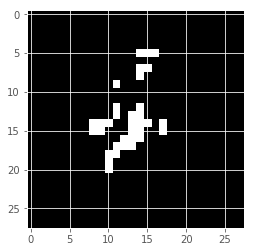

In [45]:
plt.imshow((flag*255).reshape(28,28), cmap='gray')

### Совместный учёт признаков

Соединим признаки по голосу и указанные пиксели.

In [46]:
dataset["im_short"]=list(map(lambda x: np.extract(mdl_all.feature_importances_>0.005,x),dataset["image_vector"]))
voice_features = extract_voice_features(VOICE_TRAIN_PATH, numcep=20)
voice_features["new"]= list(map(lambda x,y: np.concatenate((x, y), axis=0), 
                                voice_features["voice_vector"], dataset["im_short"]))
X = np.vstack(voice_features["new"])
y=dataset["target"]

In [47]:
for i in range(100,1001,100):
    mdl_new = RandomForestClassifier(n_estimators=i)
    print(np.mean(cross_val_score(mdl_new, X, y, cv=5, scoring='accuracy')), i)

0.9325937613809903 100
0.9360408429556099 200
0.9387167788594908 300
0.9347049800546434 400
0.9353630078771129 500
0.9379787832235552 600
0.9386630827793049 700
0.9386543242100667 800
0.9386589441618508 900
0.9373521381772573 1000


С помощью леса улучшения мы не добились. Ну что ж, попробуем бустинг.

In [48]:
for i in range(100,1001,100):
    mdl_new = GradientBoostingClassifier(n_estimators=i, learning_rate=0.1)
    print(np.mean(cross_val_score(mdl_new, X, y, cv=5, scoring='accuracy')), i)

0.9547758533411109 100
0.9574139419915682 200
0.956742801051971 300
0.9567582042866501 400
0.956751690335939 500
0.9574139419915682 600
0.9574139419915682 700
0.9574139419915682 800
0.9574139419915682 900
0.9574139419915682 1000


С ростом learning_rate как правило нужно меньшее количество шагов.

In [50]:
for i in range(100,801,100):
    mdl_new = GradientBoostingClassifier(n_estimators=i, learning_rate=0.4)
    print(np.mean(cross_val_score(mdl_new, X, y, cv=5, scoring='accuracy')), i)

0.9513889362983645 100
0.949395536666036 200
0.9507200399772943 300
0.9513889362983645 400
0.9513889362983645 500
0.9507200399772943 600
0.9507200399772943 700
0.9500644329871063 800


Кажется пикселей можно взять и побольше.

In [51]:
dataset["im_short"]=list(map(lambda x: np.extract(mdl_all.feature_importances_>0.003,x),dataset["image_vector"]))
voice_features = extract_voice_features(VOICE_TRAIN_PATH, numcep=20)
voice_features["new"]= list(map(lambda x,y: np.concatenate((x, y), axis=0), 
                                voice_features["voice_vector"], dataset["im_short"]))
X = np.vstack(voice_features["new"])
y=dataset["target"]

In [52]:
for i in range(100,1001,100):
    mdl_new = GradientBoostingClassifier(n_estimators=i)
    print(np.mean(cross_val_score(mdl_new, X, y, cv=5, scoring='accuracy')), i)

0.9580169145171473 100
0.9613771994502365 200
0.9620394511058656 300
0.9620240478711863 400
0.9607125724613503 500
0.9620394511058656 600
0.9613837134009475 700
0.9613572614794789 800
0.9620394511058656 900
0.9607214617453185 1000


Кажется,что стало получше. Сдадим бустинг в двух вариантах, когда признаков из картинок поменьше, и когда побольше.

In [55]:
n_cep=20;
n_est=800;

submit_image_features = extract_image_features(IMAGE_TEST_PATH)
submit_voice_features = extract_voice_features(VOICE_TEST_PATH, numcep=n_cep)
submit_dataset = submit_image_features.merge(
    submit_voice_features, 
    on="index"
)
submit_dataset["index"] = submit_dataset["index"].apply(int)

# voice_features = extract_voice_features(VOICE_TRAIN_PATH, numcep=n_cep)
# X = np.vstack(voice_features["voice_vector"])
# y=dataset["target"]

mdlVoB=GradientBoostingClassifier(n_estimators=n_est)
mdlVoB.fit(X,y)

submit_dataset["im_short"]=list(map(lambda x: np.extract(mdl_all.feature_importances_>0.003,x),submit_dataset["image_vector"]))
submit_dataset["new"]= list(map(lambda x,y: np.concatenate((x, y), axis=0), 
                                submit_voice_features["voice_vector"], submit_dataset["im_short"]))

guess = mdlVoB.predict(np.vstack(submit_dataset["new"]))
submit_dataset["target"] = guess

submit_dataset[["index", "target"]] \
    .sort_values("index") \
    .to_csv("sub_boost03.csv", index=False)

In [56]:
dataset["im_short"]=list(map(lambda x: np.extract(mdl_all.feature_importances_>0.005,x),dataset["image_vector"]))
voice_features = extract_voice_features(VOICE_TRAIN_PATH, numcep=20)
voice_features["new"]= list(map(lambda x,y: np.concatenate((x, y), axis=0), 
                                voice_features["voice_vector"], dataset["im_short"]))
X = np.vstack(voice_features["new"])
y=dataset["target"]

In [57]:
n_cep=20;
n_est=800;

submit_image_features = extract_image_features(IMAGE_TEST_PATH)
submit_voice_features = extract_voice_features(VOICE_TEST_PATH, numcep=n_cep)
submit_dataset = submit_image_features.merge(
    submit_voice_features, 
    on="index"
)
submit_dataset["index"] = submit_dataset["index"].apply(int)

# voice_features = extract_voice_features(VOICE_TRAIN_PATH, numcep=n_cep)
# X = np.vstack(voice_features["voice_vector"])
# y=dataset["target"]

mdlVoB=GradientBoostingClassifier(n_estimators=n_est)
mdlVoB.fit(X,y)

submit_dataset["im_short"]=list(map(lambda x: np.extract(mdl_all.feature_importances_>0.005,x),submit_dataset["image_vector"]))
submit_dataset["new"]= list(map(lambda x,y: np.concatenate((x, y), axis=0), 
                                submit_voice_features["voice_vector"], submit_dataset["im_short"]))

guess = mdlVoB.predict(np.vstack(submit_dataset["new"]))
submit_dataset["target"] = guess

submit_dataset[["index", "target"]] \
    .sort_values("index") \
    .to_csv("sub_boost05.csv", index=False)

Не фиксировал seed, примерно такое решение дало 10 место в Private Liderboard, arruracy=0.968.

Сейчас на Public части выходит 11-13 место, результат: 0.972.